### In this notebook, we show how to get all the input data for electrolyte for the col-solvent

In [2]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; 
from openpyxl import load_workbook
import sympy as sy; from sympy import symbols,diff
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os

#### Load data from: Table S3 in Jung 2023 paper. 
Jung, T.; Wang, A. A.; Monroe, C. W. Overpotential from Cosolvent Imbalance in Battery Electrolytes: LiPF(6) in EMC:EC. ACS Omega 2023, 8 (23), 21133-21144. DOI: 10.1021/acsomega.3c02088.

In [3]:
# The data file are the same from 
Path_Data_pre = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/Input/")
Save_fig = False
Jung_2023_Data = pd.read_excel(Path_Data_pre+'Jung_2023_ACS_Omega_Table_S3.xlsx')
Jung_2023_Data.head()

,omega_o,omega_e,rho (g/cm3),y_o,y_e,c_o (M),c_e (M),c_T (M)
0,0.0,0.00000,1.0061,0.0,0.00000,0.0,0.00000,9.66428
1,0.0,0.01394,1.0177,0.0,0.00950,0.0,0.09339,9.82622
2,0.0,0.07384,1.0674,0.0,0.04926,0.0,0.51886,10.53370
3,0.0,0.13444,1.1176,0.0,0.08776,0.0,0.98911,11.27030
4,0.0,0.19654,1.1691,0.0,0.12555,0.0,1.51262,12.04810


In [4]:
# Rename and change unit to International System of Units
Jung_2023_Data["rho (kg/m3)"]   = Jung_2023_Data["rho (g/cm3)"] * 1000
Jung_2023_Data["c_EC (mol/m3)"] = Jung_2023_Data["c_o (M)"] * 1000
Jung_2023_Data["c_e (mol/m3)"]  = Jung_2023_Data["c_e (M)"] * 1000
Jung_2023_Data["c_T (mol/m3)"]  = Jung_2023_Data["c_T (M)"] * 1000
Jung_2023_Data.drop('c_o (M)', axis=1, inplace=True)
Jung_2023_Data.drop('c_e (M)', axis=1, inplace=True)
Jung_2023_Data.drop('c_T (M)', axis=1, inplace=True)
Jung_2023_Data.drop('rho (g/cm3)', axis=1, inplace=True)
Jung_2023_Data.rename(columns={'omega_o': 'omega_EC'}, inplace=True)
Jung_2023_Data.rename(columns={'y_o': 'y_EC'}, inplace=True)

In [5]:
Jung_2023_Data.head()

,omega_EC,omega_e,y_EC,y_e,rho (kg/m3),c_EC (mol/m3),c_e (mol/m3),c_T (mol/m3)
0,0.0,0.00000,0.0,0.00000,1006.1,0.0,0.00,9664.28
1,0.0,0.01394,0.0,0.00950,1017.7,0.0,93.39,9826.22
2,0.0,0.07384,0.0,0.04926,1067.4,0.0,518.86,10533.70
3,0.0,0.13444,0.0,0.08776,1117.6,0.0,989.11,11270.30
4,0.0,0.19654,0.0,0.12555,1169.1,0.0,1512.62,12048.10


#### Fit density $ \rho $ as a function of $ c_\mathrm{EC} $ and $ c_\mathrm{e} $, then substitube into the following equations to get the three partial molar volume $ \bar{V}_\mathrm{e} $, $ \bar{V}_\mathrm{EC} $, $ \bar{V}_\mathrm{0} $ and total concentration $ c_\mathrm{T} $.

##### Fit ρ as a linear combination of c_EC and c_e:   $$ ρ = ρ₀ + ρ₁ c_{\text{EC}} + ρ₂ c_\text{e} \tag{S20} $$

##### According to Jung 2023, the three partial molar volumes are $$ \bar{V}_0 = \frac{\bar{m}_0}{\rho - c_{\text{EC}} \frac{\partial \rho}{\partial c_{\text{EC}}} - c_e \frac{\partial \rho}{\partial c_e}} = \frac{\bar{m}_0}{\rho_0} \tag{S23} $$ $$ \bar{V}_{\text{EC}} = \frac{\bar{m}_{\text{EC}} - \frac{\partial \rho}{\partial c_{\text{EC}}}}{\rho - c_{\text{EC}} \frac{\partial \rho}{\partial c_{\text{EC}}} - c_e \frac{\partial \rho}{\partial c_e}} = \frac{\bar{m}_{\text{EC}} - \rho_1}{\rho_0} \tag{S24} $$ $$ \bar{V}_\mathrm{e} = \frac{\bar{m}_\mathrm{e} - \frac{\partial \rho}{\partial c_\mathrm{e}}}{\rho - c_{\text{EC}} \frac{\partial \rho}{\partial c_{\text{EC}}} - c_\mathrm{e} \frac{\partial \rho}{\partial c_\mathrm{e}}} = \frac{\bar{m}_\mathrm{e} - \rho_2}{\rho_0} \tag{S25} $$

##### Then: $$ c_\mathrm{T} = \frac{\rho - (\overline{m}_\mathrm{EC} - \overline{m}_\mathrm{0}) c_\mathrm{EC} + (\overline{m}_\mathrm{e} - 2\overline{m}_\mathrm{0}) c_\mathrm{e}}{\overline{m}_\mathrm{0}} \tag{S22} $$


Fit results for rho is rho = 1006.1  + 0.02235185918895445 * c_EC + 0.10065156540490541 * c_e
RMSE=6.724186328439609, R2=0.9955257527340647


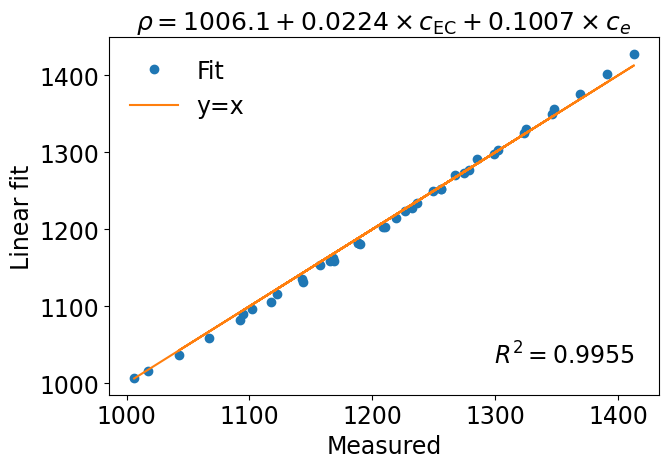

In [6]:
# Fit density as a linear function of c_EC and c_e: rho = 1006.1  + rho_1 * c_EC + rho_2 * c_e
def Fit_rho(rho,c_EC,c_e):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score

    X = np.column_stack((c_EC, c_e))

    # Adjust rho by subtracting the constant 1006.1 from each value
    rho_0 = 1006.1
    adjusted_rho = [r - rho_0 for r in rho]

    # Create a linear regression model without fitting the intercept
    model = LinearRegression(fit_intercept=False)

    # Fit the model
    model.fit(X, adjusted_rho)

    # The coefficients rho_1 and rho_2
    rho_1, rho_2 = model.coef_

    # Predict adjusted rho values using the model and add back the constant
    rho_pred = model.predict(X) + 1006.1

    # Calculate RMSE and R^2
    rmse = np.sqrt(mean_squared_error(rho, rho_pred))
    r2 = r2_score(rho, rho_pred)
    # plot result:
    fig, ax = plt.subplots(figsize=(7, 5), tight_layout='constrained')
    ax.plot(rho,rho_pred,"o",label="Fit")
    ax.plot(rho,rho,"-",label="y=x")
    ax.set_xlabel('Measured')
    ax.set_ylabel("Linear fit")
    equation = r'$\rho = 1006.1 + {:.4f} \times c_{{\text{{EC}}}} + {:.4f} \times c_e$'.format(rho_1, rho_2)
    ax.legend(loc='best',frameon=False) 
    x_pos = 0.70  # X position in normalized coordinates (e.g., 0.05 for 5% from the left)
    y_pos = 0.15  # Y position in normalized coordinates (e.g., 0.95 for 95% from the bottom, or near the top)
    #ax.text(x_pos, y_pos, f"R^2={r2:.4f}", fontsize=fs, transform=ax.transAxes, verticalalignment='top') 
    ax.text(x_pos, y_pos, r'$R^2 = {:.4f}$'.format(r2), fontsize=fs, transform=ax.transAxes, verticalalignment='top')
    ax.set_title(equation,fontsize=fs+1)
    if Save_fig:
        plt.savefig(Path_Data_pre + "/" +  f"Linear fit of rho.png", dpi=600)
        plt.savefig(Path_Data_pre + "/" +  f"Linear fit of rho.svg") 
    return rho_0,rho_1, rho_2, rho_pred, rmse, r2

rho  = Jung_2023_Data["rho (kg/m3)"].tolist() 
c_EC = Jung_2023_Data["c_EC (mol/m3)"].tolist()
c_e  = Jung_2023_Data["c_e (mol/m3)"].tolist()
rho_0, rho_1, rho_2, rho_pred, rmse, r2 = Fit_rho(rho,c_EC,c_e)
print(f"Fit results for rho is rho = {rho_0}  + {rho_1} * c_EC + {rho_2} * c_e")
print(f"RMSE={rmse}, R2={r2}")
# Get Fun_rho
def Fun_rho(c_e, c_EC):
    return rho_0  + rho_1 * c_EC + rho_2 * c_e

In [7]:
print(rho_0,rho_1,rho_2)

1006.1 0.02235185918895445 0.10065156540490541


In [8]:
# Three partial molar volume - Eq. (S23)~(S25)
m_bar_EC = 88.062*1e-3 #   kg/mol
m_bar_0  = 104.105*1e-3 #   kg/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
V_bar_0  = m_bar_0 / rho_0
V_bar_EC = (m_bar_EC - rho_1) / rho_0
V_bar_e = (m_bar_e - rho_2) / rho_0
print("Partial molar volumes are:")
print(f"EMC: {V_bar_0:.4e} m3/mol")
print(f"EC: {V_bar_EC:.4e} m3/mol")
print(f"LiPF6: {V_bar_e:.4e} m3/mol")

Partial molar volumes are:
EMC: 1.0347e-04 m3/mol
EC: 6.5312e-05 m3/mol
LiPF6: 5.0943e-05 m3/mol


In [9]:
# Total concentration c_T - Eq. (S22)
def Fun_c_T(c_e, c_EC):
    b = (
        (m_bar_EC-m_bar_0) * c_EC 
        + (m_bar_e-2*m_bar_0)*c_e  ) 
    c_T= (Fun_rho(c_e, c_EC ) - b) / m_bar_0
    return c_T

In [10]:
# del c_e, c_EC
c_e, c_EC=symbols("c_e c_EC",real=True)
c_T = Fun_c_T(c_e, c_EC)
c_0 = c_T - 2*c_e - c_EC
print(c_0)

-0.631191016868023*c_EC - 0.492324428174387*c_e + 9664.28125450266


#### Now we find values for the cation transference number $ t_+^0 $ and electro-osmotic coefficient of EC $ \widetilde{\Xi} $ in literature. 

##### In Wang 2022 $ \widetilde{\Xi}=3.0 $ and $ t_+^0=0.24 $

Ref: Wang, A. A.; Greenbank, S.; Li, G. C.; Howey, D. A.; Monroe, C. W. Current-driven solvent segregation in lithium-ion electrolytes. Cell Reports Physical Science 2022, 3 (9), 12, Article. DOI: 10.1016/j.xcrp.2022.101047.

##### Alternatively, we can also take the cation transference number $ t_+^0 $ from Landesfeind and Gasteiger
$$
t_+^0 = -7.91 + 0.245 \cdot c_e^{cor} + 0.0528 \cdot T + 0.698 \cdot (c_e^{cor})^2 - 0.0108 \cdot c_e^{cor} \cdot T - 8.21 \times 10^{-5} \cdot T^2 + 7.43 \times 10^{-4} \cdot (c_e^{cor})^3 - 2.22 \times 10^{-3} \cdot (c_e^{cor})^2 \cdot T + 3.07 \times 10^{-5} \cdot c_e^{cor} \cdot T^2
$$

Ref: J. Landesfeind, H.A. Gasteiger, Journal of The Electrochemical Society, 166 (2019) A3079-A3097.


In [11]:
# cation transference number and electro-osmotic coefficient of EC 
def t_0plus_constant(c_e, c_EC , T):
    t_0plus = (
        (c_EC >= 0 ) * 0.24
        +  (c_EC < 0 ) * 0.24 
    )
    return t_0plus
def EC_transference_number_con(c_e,c_EC, T):# Mark Ruihe add update 221212
    Xi_0 =   3.0     # pybamm.Parameter("EC transference number zero") 
    Xi = ( 
        (c_EC < 0 ) * Xi_0
        + 
        (c_EC >= 0) * Xi_0
    )
    return Xi

def electrolyte_transference_number_base_Landesfeind2019(c_e,c_EC, T, coeffs):
    c = c_e / 1000  # mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = coeffs
    tplus = (
        p1
        + p2 * c
        + p3 * T
        + p4 * c**2
        + p5 * c * T
        + p6 * T**2
        + p7 * c**3
        + p8 * c**2 * T
        + p9 * c * T**2
    )
    return tplus
def electrolyte_transference_number_EC_DMC_1_1_Landesfeind2019_Con(c_e,c_EC, T):
    coeffs = np.array(
        [
            -7.91,
            2.45e-1,
            5.28e-2,
            6.98e-1,
            -1.08e-2,
            -8.21e-5,
            7.43e-4,
            -2.22e-3,
            3.07e-5,
        ]
    )
    c_e_constant = 4000
    t0plus = (
        (c_e <= c_e_constant) * electrolyte_transference_number_base_Landesfeind2019(c_e,c_EC, T, coeffs)
        + 
        (c_e > c_e_constant) * electrolyte_transference_number_base_Landesfeind2019(c_e_constant,c_EC, T, coeffs)
    )
    return t0plus


#### Measured liquid junction potential (LJP) and its derivative.

##### $ \Delta U $ as function of $ y_\mathrm{e} $ in Jung Eq. (13): $$ \Delta U(y_e) = \frac{RT}{F} \left(1.491 \cdot \ln(y_e) + 3.007 - 8.168 \cdot y_e + 199.6 \cdot (y_e)^2\right) $$

##### $ \Delta U $ as function of $ y_\mathrm{e} $ and $ y_\mathrm{EC} $ (Eq. (17), (14), (18), (19) in Jung 2023): $$ \Delta U(y_\mathrm{EC}, y_\mathrm{e}) = \left(1 - \frac{y_\mathrm{EC}}{1 - 2y_\mathrm{e}}\right) \Delta U_{1:0}(y_\mathrm{e}) + \frac{y_\mathrm{EC}}{1 - 2y_\mathrm{e}} \Delta U_{0:1}(y_\mathrm{e}) + \Delta U_\mathrm{ex}(y_\mathrm{EC}, y_\mathrm{e}) $$      $$ \Delta U_{1:0}(y_\mathrm{e}) = \frac{RT}{F} \left(7.167 - 43.16(y_\mathrm{e})^{0.5} + 185.4(y_\mathrm{e}) - 402.4(y_\mathrm{e})^{1.5} + 236.9(y_\mathrm{e})^2 + 253.7(y_\mathrm{e})^{2.5} - 408.1(y_\mathrm{e})^3 + 2509(y_\mathrm{e})^{3.5} - 2886(y_\mathrm{e})^4.5 + 1.174 \ln(y_\mathrm{e})\right) $$  $$ \Delta U_{0:1}(y_\mathrm{e}) = \frac{RT}{F} \left(3.024 \ln(y_\mathrm{e}) + 8.233 - 88.12(y_\mathrm{e}) + 477.9(y_\mathrm{e})^2\right) $$ $$ \Delta U_\mathrm{ex}(y_\mathrm{EC}, y_\mathrm{e}) = \frac{RT}{F} \left( (y_\mathrm{EC} - y_\mathrm{EC}^2 - 2y_\mathrm{e} y_\mathrm{EC}) \cdot (32.2 - 37.99y_\mathrm{EC} - 44.8(1 - y_\mathrm{EC} - 2y_\mathrm{e})) \right) $$

In [12]:
BasicPath =  os.path.expanduser("~/EnvPBGEM_ECDrag2/SimSave/DouTrans")

In [13]:
def LJP_1_Specie_np(y_e,T):   # ALL IN ISO Units, range limit: 0< y_e <= 0.15 
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.491; a0 = 3.007; a1 = -8.168; a2 = 199.6
    delta_U = R*T/F*(
        aln * np.log(y_e) + a0 + a1*y_e  + a2 * y_e**2
    )
    return delta_U

def LJP_2_Species_np(y_e,y_EC):
    T = 298.15;
    # y0 = c0/cT;   y_e = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*np.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*np.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V

def LJP_2_Species_sy(y_e,y_EC):
    T = 298.15;
    # y0 = c0/cT;   y_e = ce/cT;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*sy.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*sy.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V


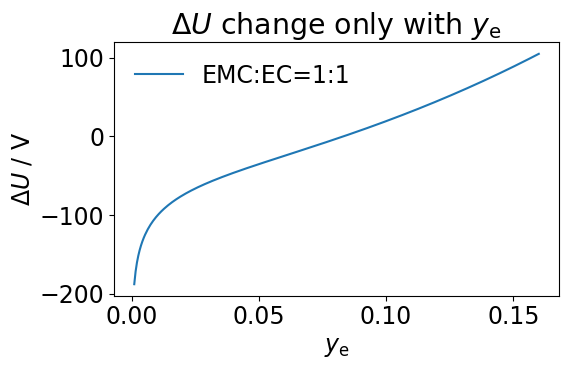

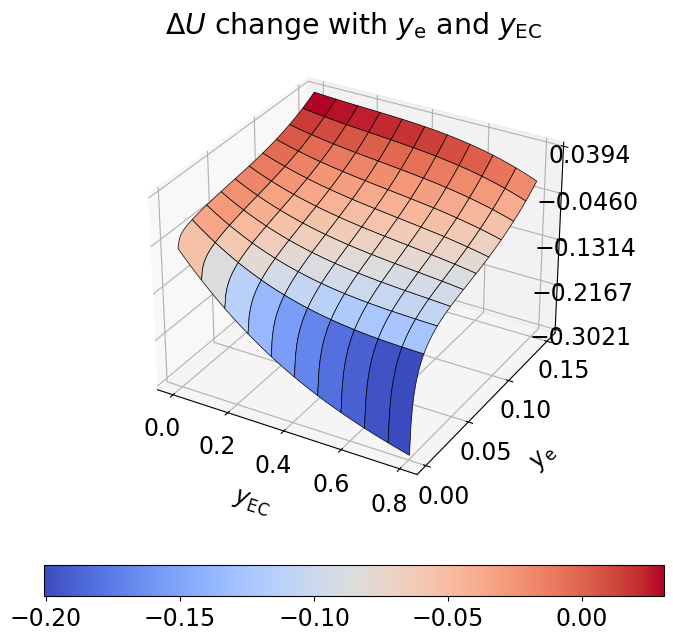

In [14]:
# plot delta_U as one species
Y_e = np.linspace(1E-3,0.16,300).tolist(); T=298.75
delta_U_1Species_1 = []; delta_U_1Species_2 = []; 
for y_e in Y_e:
    delta_U_1Species_2.append(LJP_1_Specie_np(y_e,T))
fig, ax = plt.subplots(figsize=(6, 4), tight_layout='constrained')
ax.plot(Y_e,np.array(delta_U_1Species_2)*1e3,'-',label="EMC:EC=1:1")
ax.legend(frameon=False)
ax.set_ylabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change only with $y_\mathrm{e}$")
ax.set_xlabel("$y_\mathrm{e}$")
if Save_fig:
    plt.savefig(Path_Data_pre + "/" +  f"Jung 2023 Fig. 1 LJP change with y_e.png", dpi=600)
    plt.savefig(Path_Data_pre + "/" +  f"Jung 2023 Fig. 1 LJP change with y_e.svg") 
# Plot
Y_e = np.linspace(1E-3,0.15,100).tolist(); 
Y_o = np.linspace(1E-3,0.80,100).tolist(); 
Y_o, Y_e = np.meshgrid(Y_o, Y_e)
delta_U2 = LJP_2_Species_np(Y_e,Y_o)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(20, 8))
# Plot the surface.
surf = ax.plot_surface(
    Y_o, Y_e, delta_U2,
    rstride=10, cstride=10, cmap=cm.coolwarm, # Adjusting rstride and cstride for less density
    linewidth=0.5, edgecolor='k', antialiased=True) 

ax.zaxis.set_major_locator(LinearLocator(5))

ax.set_zlabel("$\Delta U$ / V")
ax.set_title("$\Delta U$ change with $y_\mathrm{e}$ and $y_\mathrm{EC}$")
ax.set_ylabel("$y_\mathrm{e}$",)
ax.set_xlabel("$y_\mathrm{EC}$")

ax.xaxis.labelpad = 15  # Adjust the x-axis label position
ax.yaxis.labelpad = 15  # Adjust the y-axis label position
ax.zaxis.labelpad = 40  # Adjust the z-axis label position

# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:1.f}')

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, orientation='horizontal', pad=0.1, shrink=0.4)
if Save_fig:
    plt.savefig(Path_Data_pre + "/" +  f"Jung 2023 Fig. 3 LJP change with y_e and y_EC.png", dpi=600)
    plt.savefig(Path_Data_pre + "/" +  f"Jung 2023 Fig. 3 LJP change with y_e and y_EC.svg") 

##### Now we need to get  $$ \frac{\partial \Delta U}{\partial c_\mathrm{e}}, \frac{\partial \Delta U}{\partial c_\mathrm{EC}} $$
##### To start with, we need to re-defined all previous function in terms of sy instead of np. Then instead of manually derive, we just use the sy.diff function


In [15]:
import sympy as sy; from sympy import symbols,diff
def LJP_1_Specie_sy(c_e):   # ALL IN ISO Units, range limit: 0< y_e <= 0.15 
    T = 298.15
    c_EC = 6250
    c_T = Fun_c_T(c_e, c_EC)
    y_e = c_e / c_T
    # Eq. (13):
    R = 8.31446261815324
    F = 96485.3321
    aln = 1.491; a0 = 3.007; a1 = -8.168; a2 = 199.6
    delta_U = R*T/F*(
        aln * sy.log(y_e) + a0 + a1*y_e  + a2 * y_e**2
    )
    return delta_U

def LJP_2_Species_sy(c_e,c_EC):
    T = 298.15
    c_T = Fun_c_T(c_e, c_EC)
    y_EC = c_EC / c_T;   y_e = c_e / c_T;
    # constant first
    R = 8.31446261815324; F = 96485.3321
    bln = 3.024; b0 = 8.233; b1 = -88.12; b2 = 477.9;
    p = 32.2;     q = -37.99;   r = -44.80
    # Eq. (14):
    delta_U_1to0 = R*T/F*(
        7.167 - 43.16*y_e**0.5 + 185.4*y_e - 402.4*y_e**1.5 
        + 236.9*y_e**2 + 253.7*y_e**2.5 - 408.1*y_e**3 
        + 2509*y_e**3.5 - 2886*y_e**4.5 + 1.174*sy.log(y_e) 
    )
    # Eq. (18):
    delta_U_0to1 = R*T/F*(
        bln*sy.log(y_e) + b0 + b1*y_e + b2*y_e**2
    )
    # Eq. (19):
    delta_U_ex = R*T/F*  y_EC  * (
        (1-y_EC-2*y_e) * (
        p + q*y_EC + r*(1-y_EC-2*y_e)
        )
    )
    # Eq. (17):
    delta_U = (
        ( 1 - y_EC/(1-2*y_e)  ) * delta_U_1to0 
        + y_EC/(1-2*y_e) * delta_U_0to1 
        + delta_U_ex
    )
    return delta_U # units: V
# Get derivative
x,y=symbols("x y",real=True)
T = 298.15
dLJP_2_Species_dc_EC_r = diff(LJP_2_Species_sy(x,y),y)   # x: c_e; y: c_EC
dLJP_2_Species_dc_e_r = diff(LJP_2_Species_sy(x,y),x)    # x: c_e; y: c_EC
dLJP_1_Specie_dc_e_r = diff(LJP_1_Specie_sy(x),x)            # x: c_e

##### However, the equations contains sy.log, which takes quite a while to operate. To make it faster, we now need to substitube it with np.log, when using in pybamm, need to change to pybamm.log

In [16]:
print(dLJP_2_Species_dc_EC_r,"\n\n")
print(dLJP_2_Species_dc_e_r,"\n\n")
print(dLJP_1_Specie_dc_e_r,"\n\n")

-7.89754965808084e-9*x*y*(1.31463627670492e-7*x**2/(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2 - 2.26403007269705*x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 0.0776943592809339*log(x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266)) + 0.211527003955003)/((-2*x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 1)**2*(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2*(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266)) + 0.0256925791272929*y*(-3.53810224682022e-7*x/(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2 - 2.68911565857653e-8*y/(0.000156004935299578*x + 3.81620705585473e-5*y + 1)**2 + 6.81/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266))*(-2*x/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) - y/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 1)/(1.50767557182561*x + 0.368808983131977*y + 9664.28125450266) + 0.0256925791272929*y*(7.89754965808084e-9*x/(0.

In [17]:
def dLJP_2_Species_dc_EC_np(c_e,c_EC):
    return -7.89754965808084e-9*c_e*c_EC*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.0256925791272929*c_EC*(-3.53810224682022e-7*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.68911565857653e-8*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 6.81/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0256925791272929*c_EC*(7.89754965808084e-9*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 3.94877482904042e-9*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 1/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.01454209750984e-10*c_EC*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + c_EC*(-1.00338484700878e-11*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 8.94014496325669e-9*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 3.06797530286975e-10*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) - 3.94877482904042e-9*c_EC*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) + (-c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 1)*(1.32989943307757e-15*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**4 - 4.97388303528732e-12*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 - 1.88096104878324e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2.18938184642623e-9*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 6.12377610056938e-8*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 6.43473325345614e-8*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 8.90920142928264e-7*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1.31758582203603e-6*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 1.19107242247655e-10*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) + (7.89754965808084e-9*c_e*c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 3.94877482904042e-9*c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) - 1/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)))*(-1.16162410618092e-11*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 6.51678874139771e-8*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.76340417020011*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.10889171513396*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5 - 10.3386938408227*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5 + 6.51820732459422*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5 + 64.462681030378*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5 - 74.1487833613674*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5 + 0.0301630878954419*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.184138714605309) + 0.0256925791272929*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + (1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))
def dLJP_2_Species_dc_e_np(c_e,c_EC):
    return c_EC*(-3.22848499937632e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.0256925791272929*c_EC*(-1.44636127972059e-6*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 1.09929914228764e-7*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 89.6/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0256925791272929*c_EC*(3.22848499937632e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1.61424249968816e-8*c_EC/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 4.14740531538772e-10*c_EC*(-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(89.6*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 6.81*c_EC/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 12.6)/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + c_EC*(-4.1017949457966e-11*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 2.99474190980181e-7*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*(-1.61424249968816e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) - 1.61424249968816e-8*c_EC*(1.31463627670492e-7*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 - 2.26403007269705*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 0.0776943592809339*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.211527003955003)/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2) + (-c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 1)*(5.43657280581555e-15*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**4 - 5.5181747304683e-11*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 5.34428802806659e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.76340417020011/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.10889171513396*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5*(-8.07121249844079e-9*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 0.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e - 10.3386938408227*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5*(-2.42136374953224e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e + 6.51820732459422*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5*(-4.0356062492204e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e + 64.462681030378*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5*(-5.64984874890856e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 3.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e - 74.1487833613674*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5*(-7.26409124859671e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.5/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e + 0.0301630878954419*(-1.61424249968816e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 1/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)/c_e) + (-c_EC*(-3.22848499937632e-8*c_e/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 2/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)**2*(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 1.61424249968816e-8*c_EC/((-2*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) + 1)*(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2))*(-1.16162410618092e-11*c_e**3/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**3 + 6.51678874139771e-8*c_e**2/(0.000156004935299578*c_e + 3.81620705585473e-5*c_EC + 1)**2 + 4.76340417020011*c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266) - 1.10889171513396*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**0.5 - 10.3386938408227*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**1.5 + 6.51820732459422*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**2.5 + 64.462681030378*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**3.5 - 74.1487833613674*(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266))**4.5 + 0.0301630878954419*np.log(c_e/(1.50767557182561*c_e + 0.368808983131977*c_EC + 9664.28125450266)) + 0.184138714605309)
def dLJP_1_Specie_dc_e_np(c_e):
    return -9.01770046675714e-12*c_e**2/(0.000125961489893485*c_e + 1)**3 + 7.37994000756151e-8*c_e/(0.000125961489893485*c_e + 1)**2 - 0.209856986311729/(1.50767557182561*c_e + 11969.3373990775) + 0.0383076354787938*(1.50767557182561*c_e + 11969.3373990775)*(-1.05236811106346e-8*c_e/(0.000125961489893485*c_e + 1)**2 + 1/(1.50767557182561*c_e + 11969.3373990775))/c_e


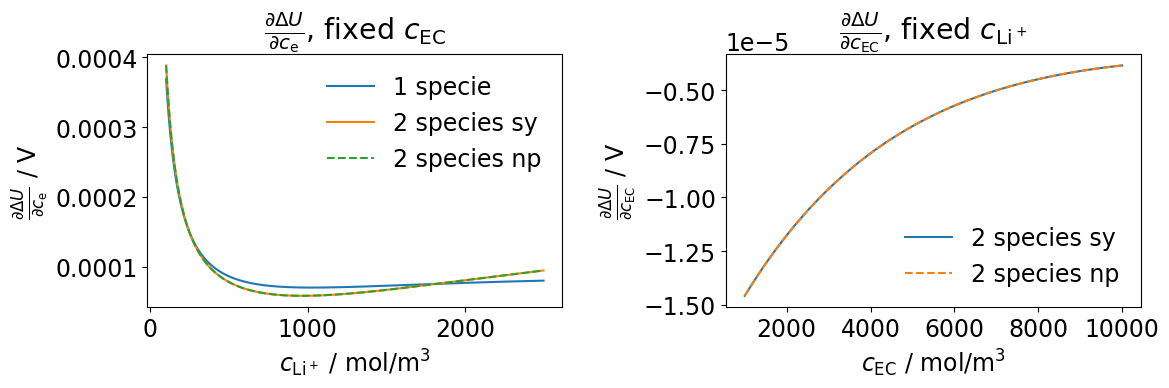

In [18]:
# Substitube in some values and plot, to confirm that the substitution is correct (sy.log -> np.log)
c_EC_1_specie = 5622.86         # When c_e=1000 mol/m3, c_EC=5622.86, c_T=13245.72 mol/m3
C_e = np.linspace(100,2.5E3,300).tolist(); T=298.75
C_EC = np.linspace(1E3,1E4,300).tolist(); 
dLJP_1_Specie_dc_e_r_sub=[]
dLJP_2_Species_dc_e_r_sub=[]
dLJP_2_Species_dc_EC_r_sub=[]
dLJP_1_Specie_dc_e_np_sub=[]
dLJP_2_Species_dc_e_np_sub=[]
dLJP_2_Species_dc_EC_np_sub=[]
for ce in C_e:
    dLJP_1_Specie_dc_e_r_sub.append(dLJP_1_Specie_dc_e_r.subs({x:ce}))
    dLJP_1_Specie_dc_e_np_sub.append(dLJP_1_Specie_dc_e_np(ce))
    dLJP_2_Species_dc_e_r_sub.append(dLJP_2_Species_dc_e_r.subs({x:ce,y:c_EC_1_specie}))
    dLJP_2_Species_dc_e_np_sub.append(dLJP_2_Species_dc_e_np(ce,c_EC_1_specie))
for cec in C_EC:
    dLJP_2_Species_dc_EC_r_sub.append(dLJP_2_Species_dc_EC_r.subs({x:1e3,y:cec}))
    dLJP_2_Species_dc_EC_np_sub.append(dLJP_2_Species_dc_EC_np(1e3,cec))

fig, axs = plt.subplots(1,2, figsize=(12,4.2),tight_layout=True)
axs[0].plot(C_e, np.array(dLJP_1_Specie_dc_e_r_sub),"-",label="1 specie")
axs[0].plot(C_e,np.array(dLJP_2_Species_dc_e_r_sub),"-",label="2 species sy")
axs[0].plot(C_e,np.array(dLJP_2_Species_dc_e_np_sub),"--",label="2 species np")
axs[1].plot(C_EC,np.array(dLJP_2_Species_dc_EC_r_sub),"-",label="2 species sy")
axs[1].plot(C_EC,np.array(dLJP_2_Species_dc_EC_np_sub),"--",label="2 species np")
for i in range(2): 
    axs[i].legend(loc='best',frameon=False)  
axs[0].set_ylabel(r'$\frac{\partial \Delta U}{\partial c_\mathrm{e}}$ / V')
axs[0].set_title(r'$\frac{\partial \Delta U}{\partial c_\mathrm{e}}$, fixed $c_\mathrm{EC}$')
axs[0].set_xlabel(r"$c_\mathrm{Li^+}$ / mol/$\mathrm{m}^3$")


axs[1].set_ylabel(r'$\frac{\partial \Delta U}{\partial c_\mathrm{EC}}$ / V')
axs[1].set_title(r'$\frac{\partial \Delta U}{\partial c_\mathrm{EC}}$, fixed $c_\mathrm{Li^+}$')
axs[1].set_xlabel(r"$c_\mathrm{EC}$ / mol/$\mathrm{m}^3$")
if Save_fig:
    plt.savefig(Path_Data_pre + "/" +  f"Critical input dLJP_dc change with y_e or y_EC.png", dpi=600)
    plt.savefig(Path_Data_pre + "/" +  f"Critical input dLJP_dc change with y_e or y_EC.svg") 

/tmp/ipykernel_699/711035922.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap  = mpl.cm.get_cmap("cool", len(y_e_list))


/tmp/ipykernel_699/711035922.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cop2 = mpl.cm.get_cmap("copper", len(Cases))


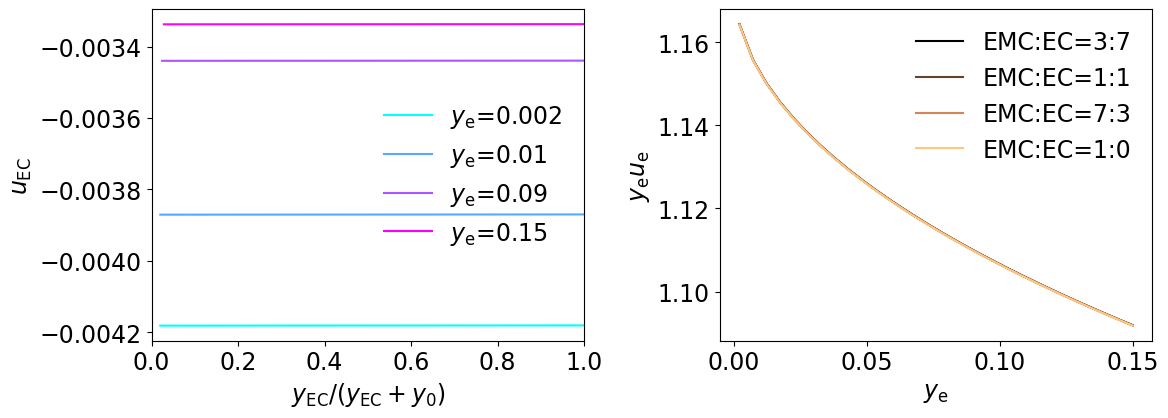

In [19]:
# To ensure we have the right derivative of LJP, we now compare with Fig. 5 and 6 in Jung 2023 paper
def Fun_u_EC(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    x,y=symbols("x y",real=True)
    d_deltaU_dyEC = diff(LJP_2_Species_sy(x,y),y) # x: y_e; y: y_EC
    u_EC = F/(R*T) * d_deltaU_dyEC.subs({x:y_e,  y:y_EC })
    return u_EC

def Fun_y_e_u_e(y_e, y_EC): # Eq. (12) in Jung 2023 paper
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321
    x,y=symbols("x y",real=True)
    d_deltaU_dye = diff(LJP_2_Species_sy(x,y),x) # x: y_e; y: y_EC
    u_e = F/(R*T) * d_deltaU_dye.subs({x:y_e,  y:y_EC })
    return u_e * y_e

def Plot_Fig_5_6_Jung2023():

    return

fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
# plot the first one:
y_e_list = [0.002, 0.01, 0.09, 0.15]
T=298.75
y_EC_array = np.linspace(0.02,1.00,30)
cmap  = mpl.cm.get_cmap("cool", len(y_e_list)) 

for i in range(len(y_e_list)):
    x_plot = y_EC_array / (1-2*y_e_list[i])
    y_plot = []
    for y_EC in y_EC_array:
        y_plot.append(Fun_u_EC(y_e_list[i], y_EC))
    axs[0].plot(x_plot, y_plot,"-",color=cmap(i),label=r"$y_\mathrm{e}$=" + f"{y_e_list[i]}")
axs[0].set_xlim(0,1)
axs[0].set_xlabel("$y_\mathrm{EC} / (y_\mathrm{EC}+y_\mathrm{0})$")
axs[0].set_ylabel("$u_\mathrm{EC}$")
axs[0].legend(frameon=False)
# Plot the second one:
y_e_array = np.linspace(0.002,0.15,30)
# EMC:EC=3:7, 1:1, 7:3, 1:0
Cases = ["EMC:EC=3:7", "EMC:EC=1:1", "EMC:EC=7:3", "EMC:EC=1:0"]
cop2 = mpl.cm.get_cmap("copper", len(Cases))
Ratios = [7/10, 1/2, 3/10, 0]
for i in range(len(Cases)):
    x_plot = y_e_array
    y_plot = []
    for y_e in y_e_array:
        y_EC = (1-2*y_e) * Ratios[i]
        y_plot.append( Fun_y_e_u_e(y_e, y_EC)  ) 
    axs[1].plot(x_plot, y_plot,"-",color=cop2(i),label=Cases[i])
axs[1].set_ylabel("$y_\mathrm{e}u_\mathrm{e}$")
axs[1].set_xlabel("$y_\mathrm{e}$")
axs[1].legend(frameon=False)
if Save_fig:
    plt.savefig(Path_Data_pre + "/" +  f"Jung 2023 Fig. 5 and 6 - Junction Coefficients.png", dpi=600)
    plt.savefig(Path_Data_pre + "/" +  f"Jung 2023 Fig. 5 and 6 - Junction Coefficients.svg") 

#### Based on the discussion in this work, we can now determine the thermodynamic factors and conductivity.

##### We assume $ X_\mathrm{e,EC}=0 $, $ X_\mathrm{EC,e}=0 $, then:
$$ X_\mathrm{e,e}=2X_\mathrm{EC,EC} \tag{36} $$
$$ \frac{\partial \Delta U}{\partial c_\mathrm{e}} = \frac{\kappa RT(2 + X_\mathrm{e,e})}{F\overline{V}_0 c_\mathrm{T}^2} \left[ (\overline{V}_\mathrm{e} - 2\overline{V}_\mathrm{0}) c_\mathrm{EC} \left(\frac{-1}{2}\right) \widetilde{\Xi} + \left(1 - (\overline{V}_\mathrm{EC} - \overline{V}_0) c_\mathrm{EC}\right) (1 - t_+^0) \frac{c_\mathrm{T}}{c_\mathrm{e}} \right] \tag{37} $$

$$
A = \left((\overline{V}_\text{e} - 2\overline{V}_0) c_\text{EC} \cdot \left(\frac{-1}{2}\right) \widetilde{\Xi} + \left(1 - (\overline{V}_\text{EC} - \overline{V}_0) c_\text{EC}\right) (1 - t_+^0) \frac{c_\text{T}}{c_\text{e}}\right)
$$
$$
B = \frac{\kappa R T}{F\overline{V}_0 c_\text{T}^2}
$$
$$
X_{\text{e,e}} = \frac{\frac{\partial\Delta U}{\partial c_\text{e}}}{A \cdot B} - 2
$$

##### In Eq. (37), to get $ X_\mathrm{e,e} $, we need to know the ionic conductivity $ \kappa $ first. We can assume it is constant of 0.7, or take values from Landesfeind and Gasteiger

$$
κ_{\mathrm{e}} = 0.1 \cdot 0.798 \cdot (1 + (T - 228)) \cdot c_{\mathrm{e}}^{\mathrm{cor}} \cdot \left(1 - 1.22 \cdot \sqrt{c_{\mathrm{e}}^{\mathrm{cor}}} + 0.509 \cdot \left(1 - 4000 \cdot e^{\frac{1000}{T}}\right) \cdot c_{\mathrm{e}}^{\mathrm{cor}}\right) \Bigg/ \left(1 + (c_{\mathrm{e}}^{\mathrm{cor}})^4 \cdot (0.00379 \cdot e^{\frac{1000}{T}})\right)
$$

$$
c_\text{e}^\text{cor} =
\begin{cases}
\frac{c_\text{e}}{1000}, & \text{if } c_\text{e} < 4000 \\
4, & \text{if } c_\text{e} \geq 4000
\end{cases}
$$


Ref: J. Landesfeind, H.A. Gasteiger, Journal of The Electrochemical Society, 166 (2019) A3079-A3097.


In [20]:
# Define ionic conductivity
def cond_constant(c_e, c_EC , T):
    cond = (
        (c_EC >= 0 ) * 0.5
        +  (c_EC < 0 ) * 0.5
    )
    return cond


def electrolyte_conductivity_base_Landesfeind2019(c_e,c_EC, T, coeffs):
    c = (
        (c_e >= 0 ) * c_e / 1000 
        +  (c_e < 0 ) * 0  
        )# mol.m-3 -> mol.l
    p1, p2, p3, p4, p5, p6 = coeffs
    A = p1 * (1 + (T - p2))
    B = 1 + p3 * np.sqrt(c) + p4 * (1 + p5 * np.exp(1000 / T)) * c
    C = 1 + c**4 * (p6 * np.exp(1000 / T))
    sigma_e = A * c * B / C  # mS.cm-1
    return sigma_e / 10
def electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019_Con(c_e,c_EC, T):
    coeffs = np.array([7.98e-1, 2.28e2, -1.22, 5.09e-1, -4e-3, 3.79e-3])
    c_e_constant = 4000
    sigma = (
        (c_e <= c_e_constant) * electrolyte_conductivity_base_Landesfeind2019(c_e,c_EC, T, coeffs)
        +
        (c_e >  c_e_constant) * electrolyte_conductivity_base_Landesfeind2019(c_e_constant,c_EC, T, coeffs)
    )
    return sigma


In [21]:
Save_fig = False

In [22]:
# these two X_ij can be a function of c_e and c_EC can don't have to involve diffusivity!
def Fun_X_e_e(c_e, c_EC , T):
    T  = 298.15
    # constant first
    R = 8.31446261815324; F = 96485.3321

    # use constant 
    Xi_tilde = EC_transference_number_con(c_e,c_EC, T)
    t_0plus  = t_0plus_constant(c_e, c_EC , T)
    c_T      = Fun_c_T(c_e, c_EC)
    cond     = cond_constant(c_e, c_EC , T) # electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019_Con(c_e,c_EC, T) # 

    A = (
        (V_bar_e-2*V_bar_0)*c_EC*(-1/2)*Xi_tilde    +
        (1 -  (V_bar_EC-V_bar_0)*c_EC   )  *  (1-t_0plus)*   (c_T / c_e)   )
    B = cond * R*T   / (F*V_bar_0*c_T**2)
    X_e_e = dLJP_2_Species_dc_e_np(c_e,c_EC) / (A*B) - 2
    return X_e_e
def Fun_X_EC_EC(c_e, c_EC , T):
    return 2*Fun_X_e_e(c_e, c_EC , T)


/tmp/ipykernel_699/531665697.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("cool", len(c_EC_List))


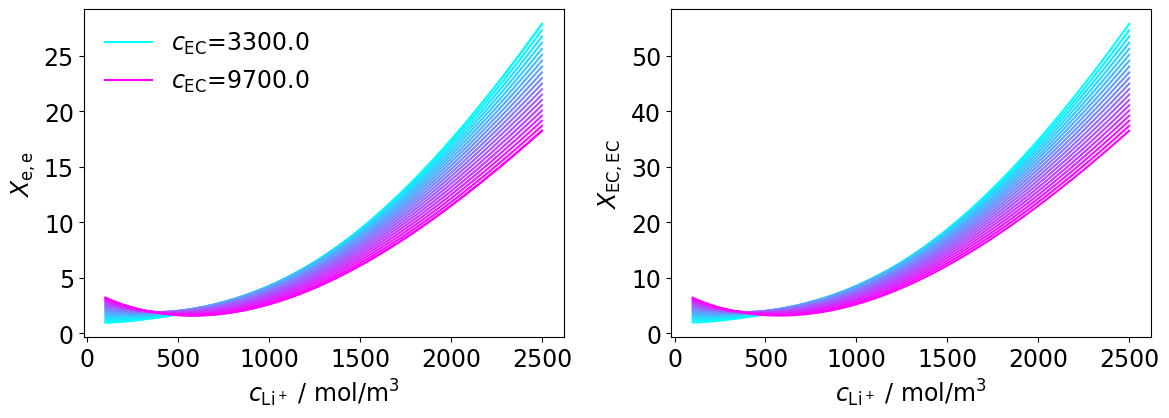

In [23]:
# Have a look at how the thermodynamic factors look like:
C_e = np.linspace(100,2.5E3,300); T=298.75
c_EC_List = np.linspace(3300,9700,20).tolist()
cmap = mpl.cm.get_cmap("cool", len(c_EC_List)) 
def Plot_X_ee_EC():
    fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
    axs[0].plot(C_e, Fun_X_e_e(C_e,  c_EC_List[0] , T),"-",color=cmap(0), label="$c_\mathrm{EC}$=" + f"{c_EC_List[0]}")
    axs[0].plot(C_e, Fun_X_e_e(C_e,  c_EC_List[-1] ,T),"-",color=cmap(19),label="$c_\mathrm{EC}$=" + f"{c_EC_List[-1]}")
    for i in range(len(c_EC_List)):
        axs[0].plot(C_e, Fun_X_e_e(C_e,  c_EC_List[i] , T),"-",color=cmap(i))
        axs[1].plot(C_e, Fun_X_EC_EC(C_e, c_EC_List[i] , T),"-",color=cmap(i))
    for i in range(2): 
        axs[i].set_xlabel(r"$c_\mathrm{Li^+}$ / mol/$\mathrm{m}^3$")
    axs[0].set_ylabel(r"$ X_\mathrm{e,e} $")
    axs[1].set_ylabel(r"$ X_\mathrm{EC,EC} $")
    axs[0].legend(loc='best',frameon=False)  
    return
Plot_X_ee_EC()
if Save_fig:
    plt.savefig(Path_Data_pre + "/" +  f"Input - X_e_e and X_EC_EC.png", dpi=600)
    plt.savefig(Path_Data_pre + "/" +  f"Input - X_e_e and X_EC_EC.svg") 

#### Now we determine the diffusivities. That involves:

##### Dimensionless molarity conversion matrix $ \boldsymbol{C} $

$$
\boldsymbol{C} = \begin{bmatrix}
C_{\text{11}} & C_{\text{12}} \\
C_{\text{21}} & C_{\text{22}}
\end{bmatrix} = \begin{bmatrix}
1 + \frac{c_\text{e}}{c_0} + \frac{(\overline{V}_\text{EC} c_\text{EC})}{(\overline{V}_0 c_0)} & \frac{(\overline{V}_\text{e} - 2\overline{V}_0) c_\text{EC}}{(\overline{V}_0 c_0)} \\
\frac{(\overline{V}_\text{EC} - \overline{V}_0) c_\text{e}}{(\overline{V}_0 c_0)} & 1 + \frac{c_\text{EC}}{c_0} + \frac{(\overline{V}_\text{e} c_\text{e})}{(\overline{V}_0 c_0)}
\end{bmatrix}  \tag{33} 
$$

##### The dimensionless thermodynamic matrix $ \boldsymbol{X} $

$$
\boldsymbol{X} = \begin{bmatrix}
1 + X_\mathrm{oo} & X_\mathrm{oe} \\
X_\mathrm{eo} & 2 + X_\mathrm{ee}
\end{bmatrix}  \tag{32} 
$$


##### Thermodynamic diffusivity matrix $ \boldsymbol{\mathcal{D}} $

$$
\boldsymbol{\mathcal{D}} = \begin{bmatrix}
\mathcal{D}_o & \frac{\mathcal{D}_{\times} c_o}{c_T} \\
\frac{\mathcal{D}_{\times} c_e}{c_T} & \mathcal{D}_e
\end{bmatrix} \tag{31} 
$$


##### Fickian diffusivity matrix $ \boldsymbol{D} $

$$
\boldsymbol{D} = \begin{bmatrix}
D_{\text{EC},\text{EC}}^0 & D_{\text{EC},\text{e}}^0 \\
D_{\text{e},\text{EC}}^0 & D_{\text{ee}}^0
\end{bmatrix}  \tag{30} 
$$

##### And their relationship:
$$
\boldsymbol{D} = \boldsymbol{\mathcal{D}}\boldsymbol{XC} \tag{30} 
$$

##### Assume:

$$
D_{\text{EC},\text{EC}}^0 = 5 \times 10^{-10} \, \text{m}^2/\text{s}
$$

$$
D_{\text{ee}}^0 = 3 \times 10^{-10} \, \text{m}^2/\text{s}
$$

##### We also know the relation between the two off-diagonal element in the Fickian diffusivity matrix :

$$
D_{\text{EC},\text{e}}^0 = D_{\text{EC},\text{EC}}^0 \cdot \frac{C_{\text{12}}}{C_{\text{11}}} + 2 \frac{c_\text{EC}}{c_\text{e}} \left(\frac{C_{\text{22}}}{C_{\text{11}}} - \frac{C_{\text{12}} \cdot C_{\text{21}}}{C_{\text{11}}^2}\right) \cdot \left(D_{(\text{e},\text{EC})}^0 - \frac{\left(D_{(\text{e},\text{EC})}^0 \cdot C_{\text{12}} - D_{\text{ee}}^0 \cdot C_{\text{11}}\right) \cdot C_{\text{21}}}{C_{\text{21}} \cdot C_{\text{12}} - C_{\text{22}} \cdot C_{\text{11}}}\right)  \tag{41} 
$$

##### We can just assume $ D_{\mathrm{EC},\mathrm{EC}}^0 $ to be the "freely unknown" parameter, and use $ \det(\boldsymbol{D}) > 0 $ to determine its range. Once we get $ D_{\mathrm{EC},\mathrm{EC}}^0 $, we can use Eq. (41) to get $ D_{\text{EC},\text{e}}^0 $ and use the following equations to get the three thermodynamic diffusivities.


$$
\mathcal{D}_\mathrm{e} = \frac{D_\mathrm{e,EC}^0 \cdot C_\mathrm{12} - D_\mathrm{ee}^0 \cdot C_\mathrm{11}}{2(1 + X_\mathrm{EC,EC}) \cdot (C_\mathrm{21} \cdot C_\mathrm{12} - C_\mathrm{22} \cdot C_\mathrm{11})} \tag{38} 
$$

$$
\mathcal{D}_\mathrm{\times} = \frac{D_\mathrm{e,EC}^0}{1 + X_\mathrm{EC,EC}} - \frac{D_\mathrm{e,EC}^0 \cdot C_\mathrm{12} - D_\mathrm{ee}^0 \cdot C_\mathrm{11}}{(1 + X_\mathrm{EC,EC}) \cdot (C_\mathrm{21} \cdot C_\mathrm{12} - C_\mathrm{22} \cdot C_\mathrm{11})} \cdot \frac{c_T}{c_e \cdot C_\mathrm{11}} \tag{39} 
$$

$$
\mathcal{D}_\mathrm{EC} = \frac{D_\mathrm{EC,EC}^0}{1 + X_\mathrm{EC,EC}} - 2 \cdot \frac{c_\mathrm{EC} \cdot C_\mathrm{21}}{c_e \cdot C_\mathrm{11}} \cdot \left(\frac{D_\mathrm{e,EC}^0}{1 + X_\mathrm{EC,EC}} - \frac{D_\mathrm{e,EC}^0 \cdot C_\mathrm{12} - D_\mathrm{ee}^0 \cdot C_\mathrm{11}}{(1 + X_\mathrm{EC,EC}) \cdot (C_\mathrm{21} \cdot C_\mathrm{12} - C_\mathrm{22} \cdot C_\mathrm{11})}\right) \cdot \frac{1}{C_\mathrm{11}} \tag{40} 
$$

In [24]:
def diff_constant_3E_10(c_e, c_EC , T):
    D_Li = (
        (c_EC >= 0 ) * 3e-10
        +  (c_EC < 0 ) * 3e-10 
    )
    return D_Li

def EC_diffusivity_5E_10(c_e, c_EC , T):
    D_ec_dim = (
        (c_EC >= 0 ) * 5e-10
        +  (c_EC < 0 ) * 0 
    )
    return D_ec_dim

In [25]:
# Now we make D_0_e_EC as an unknown, and write it as a function of D_0_e_EC
def Fun_D_0_EC_e(c_e, c_EC , D_0_e_EC):   # Eq. (41)
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    D_0_EC_e = (
        D_0_EC_EC*C_12/C_11          + 
        2 * c_EC/c_e * (C_22/C_11 - C_12*C_21/(C_11*C_11)  ) * (
            D_0_e_EC -  (D_0_e_EC*C_12 - D_0_e_e*C_11)*C_21 / (C_21*C_12-C_22*C_11)     
        )
    )
    return D_0_EC_e


def Fun_det_D(c_e, c_EC , D_0_e_EC):
    D_0_EC_EC  = 5E-10
    D_0_e_e    = 3e-10
    D_0_EC_e = Fun_D_0_EC_e(c_e, c_EC , D_0_e_EC)
    det_D = D_0_e_e*D_0_EC_EC - D_0_e_EC*D_0_EC_e
    return det_D

def Fun_curly_D_e(c_e, c_EC , D_0_e_EC):   # Eq. (38)
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    T  = 298.15
    X_EC_EC = Fun_X_EC_EC(c_e, c_EC , T)

    numerator = D_0_e_EC * C_12 - D_0_e_e * C_11
    denominator = 2 * (1 + X_EC_EC) * (C_21 * C_12 - C_22 * C_11)
    return numerator / denominator

def Fun_curly_D_x(c_e, c_EC , D_0_e_EC):
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    T  = 298.15
    X_EC_EC = Fun_X_EC_EC(c_e, c_EC , T)

    first_term = D_0_e_EC / (1 + X_EC_EC)
    second_term_numerator = D_0_e_EC * C_12 - D_0_e_e * C_11
    second_term_denominator = (1 + X_EC_EC) * (C_21 * C_12 - C_22 * C_11)
    second_term = second_term_numerator / second_term_denominator
    return first_term - second_term * ( c_T / (c_e * C_11) )

def Fun_curly_D_EC(c_e, c_EC , D_0_e_EC):
    # Pre-condition
    D_0_EC_EC  = 5E-10
    D_0_e_e = 3e-10
    c_T = Fun_c_T(c_e, c_EC)
    c_0 = c_T - 2*c_e - c_EC 
    C_11 = 1 + c_e/c_0 + (V_bar_EC*c_EC)/(V_bar_0*c_0)
    C_12 = (V_bar_e-2*V_bar_0)*c_EC / (V_bar_0*c_0)
    C_21 = (V_bar_EC- V_bar_0)*c_e  / (V_bar_0*c_0)
    C_22 = 1 + c_EC/c_0 + (V_bar_e*c_e)/(V_bar_0*c_0)
    T  = 298.15
    X_EC_EC = Fun_X_EC_EC(c_e, c_EC , T)

    first_term = D_0_EC_EC / (1 + X_EC_EC)
    second_term_numerator = D_0_e_EC * C_12 - D_0_e_e * C_11
    second_term_denominator = (1 + X_EC_EC) * (C_21 * C_12 - C_22 * C_11)
    second_term = 2 * (c_EC * C_21) / (c_e * C_11) * ( 
        D_0_e_EC / (1 + X_EC_EC)   - 
        second_term_numerator / second_term_denominator)
    return first_term - second_term / C_11



##### To get the range for $ D_{\mathrm{EC},\mathrm{EC}}^0 $, we need to know $ c_\mathrm{e} $ and $ c_\mathrm{EC} $. We take all 40 combinations from experiment to do that (need to exclude cases where either concentration is zero), and take the smallest value / range

Based on experiment measured data points, the upper bound of D_0_e_EC should be 2.61e-11 m2/s


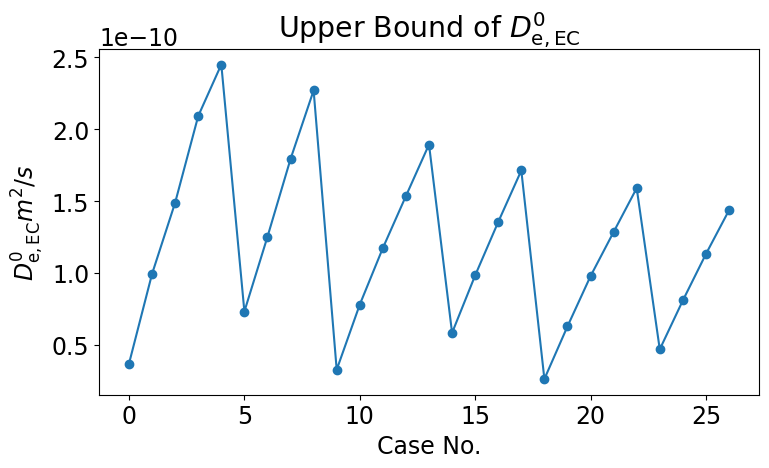

In [26]:
# determine upper bound of D_0_e_EC 
from sympy import symbols, Eq, solve
Jung_2023_Data_f1 = Jung_2023_Data[Jung_2023_Data["c_e (mol/m3)"] != 0]
Jung_2023_Data_f1 = Jung_2023_Data_f1[Jung_2023_Data_f1["c_EC (mol/m3)"] != 0]
Jung_2023_Data_f1= Jung_2023_Data_f1.reset_index(drop=True)
# Jung_2023_Data_f1
c_EC_exp_List = Jung_2023_Data_f1["c_EC (mol/m3)"].tolist()
c_e_exp_List  = Jung_2023_Data_f1["c_e (mol/m3)"].tolist()
D_0_e_EC = symbols("D_0_e_EC",real=True)
D_0_e_EC_Bound = []
for i in range(len(c_e_exp_List)):
    det_D = Fun_det_D(c_e_exp_List[i], c_EC_exp_List[i] , D_0_e_EC)
    Eq_1 =Eq(det_D ,0)
    D_0_e_EC_i = solve(Eq_1,D_0_e_EC)
    # print(D_0_e_EC_i) # this is a list, has 2 elements, the first one is negative, pick the seceond one
    D_0_e_EC_Bound.append(D_0_e_EC_i[-1])
fig, ax = plt.subplots(figsize=(8, 5), tight_layout='constrained')
ax.plot(D_0_e_EC_Bound,"-o")
ax.set_ylabel(r'$D_\mathrm{e,EC}^\mathrm{0}  m^2/s$')
ax.set_title(r'Upper Bound of $D_\mathrm{e,EC}^\mathrm{0}$')
ax.set_xlabel("Case No.")
number = min(D_0_e_EC_Bound)
formatted_number = f"{number:.2e}" 
print("Based on experiment measured data points, the upper bound "
      f"of D_0_e_EC should be {formatted_number} m2/s")
if Save_fig:
    plt.savefig(Path_Data_pre + "/" +  f"Upper bound of D_0_e,EC.png", dpi=600)
    plt.savefig(Path_Data_pre + "/" +  f"Upper bound of D_0_e,EC.svg") 

##### In this work, we assume three values of $ D_{\text{e},\text{EC}}^0 $: 0, 2.5E-13, 2.5E-11 m2/s. Now we have a look at what the remaining 4 diffusivities looks like.


In [27]:
c_EC_exp_List = Jung_2023_Data_f1["c_EC (mol/m3)"].tolist()
c_EC_exp_List.sort()
print(c_EC_exp_List,len(c_EC_exp_List))

[3288.89, 3344.44, 3396.84, 3479.0299999999997, 3553.0, 3603.32, 3648.81, 3685.14, 3717.86, 5745.49, 5872.55, 5991.95, 6105.79, 6211.13, 6310.81, 6402.07, 6473.42, 6539.22, 8425.5, 8620.67, 8805.6, 8984.39, 9152.08, 9320.550000000001, 9476.35, 9589.83, 9695.4] 27


/tmp/ipykernel_699/981413170.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("cool", len(c_EC_List))


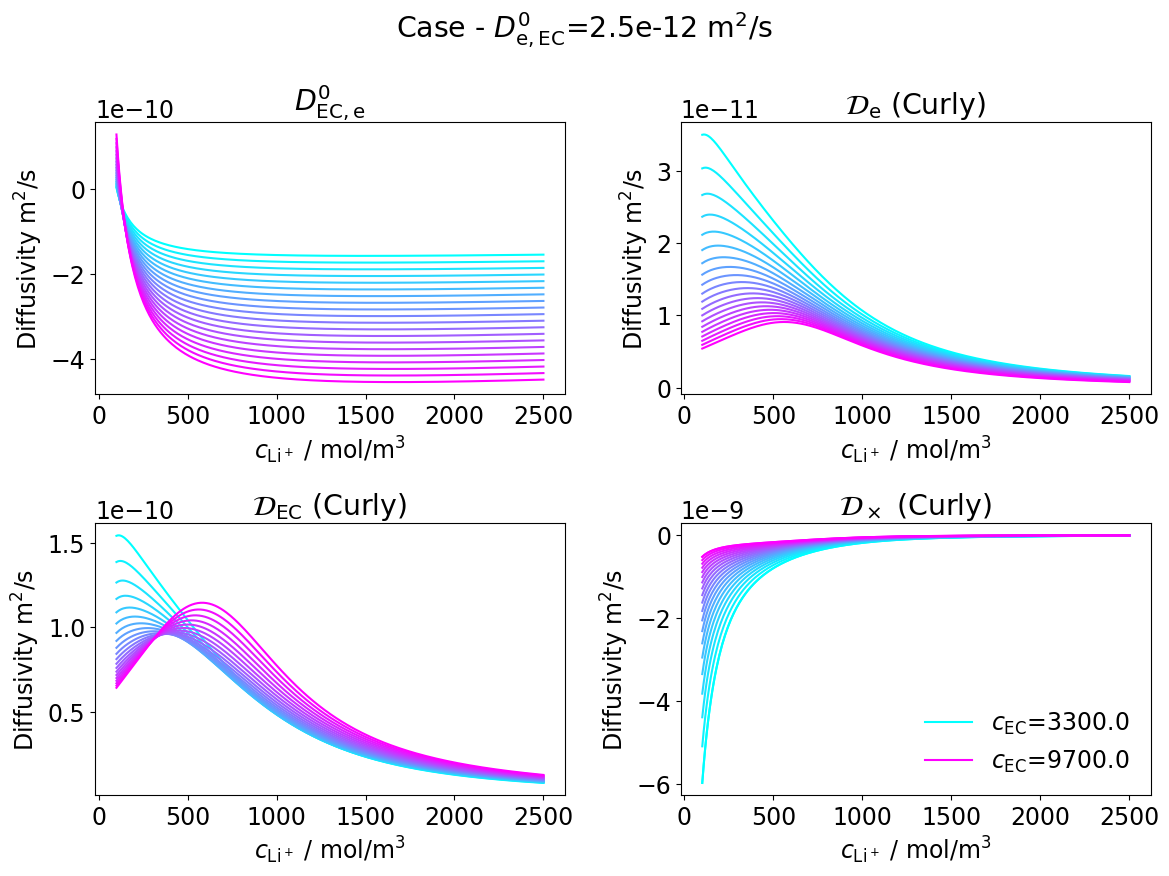

In [32]:
# Fun_D_0_EC_e, Fun_curly_D_e, Fun_curly_D_e, Fun_curly_D_x, Fun_curly_D_EC
C_e = np.linspace(100,2.5E3,300); T=298.75
c_EC_List = np.linspace(3300,9700,20).tolist()
cmap = mpl.cm.get_cmap("cool", len(c_EC_List)) 
def Plot_4_Diff(D_0_e_EC):
    Titiles = [
        r'$ D_{\mathrm{EC},\mathrm{e}}^0$',
        r'$\mathcal{D}_\mathrm{e}$ (Curly)',
        r'$\mathcal{D}_\mathrm{EC}$ (Curly)',
        r'$\mathcal{D}_\times$ (Curly)',
    ]
    # (c_e, c_EC , D_0_e_EC)
    fig, axss = plt.subplots(2,2, figsize=(12,9),tight_layout=True)
    axs   = axss.flatten()
    axs[3].plot(C_e, Fun_curly_D_x(C_e,  c_EC_List[0] , D_0_e_EC),"-",color=cmap(0), label="$c_\mathrm{EC}$=" + f"{c_EC_List[0]}")
    axs[3].plot(C_e, Fun_curly_D_x(C_e,  c_EC_List[-1] ,D_0_e_EC),"-",color=cmap(19),label="$c_\mathrm{EC}$=" + f"{c_EC_List[-1]}")
    for i in range(len(c_EC_List)):
        axs[0].plot(C_e, Fun_D_0_EC_e(C_e,  c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))
        axs[1].plot(C_e, Fun_curly_D_e(C_e, c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))
        axs[2].plot(C_e, Fun_curly_D_EC(C_e,  c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))
        axs[3].plot(C_e, Fun_curly_D_x(C_e, c_EC_List[i] , D_0_e_EC),"-",color=cmap(i))

    for i in range(4): 
        axs[i].set_xlabel(r"$c_\mathrm{Li^+}$ / mol/$\mathrm{m}^3$")
        axs[i].set_ylabel(r'Diffusivity $\mathrm{m}^2/\mathrm{s}$')
        axs[i].set_title(Titiles[i])
    axs[3].legend(loc='best',frameon=False)  
    fig.suptitle(r"Case - $D_\mathrm{e,EC}^\mathrm{0}$"+f"={D_0_e_EC}"+r" m$^2$/s")
    if Save_fig:
        plt.savefig(Path_Data_pre + "/" +  f"Four diffusivities when D_0_e,EC={D_0_e_EC}.png", dpi=600)
        plt.savefig(Path_Data_pre + "/" +  f"Four diffusivities when D_0_e,EC={D_0_e_EC}.svg") 
    return
#Plot_4_Diff(D_0_e_EC = 2.5E-11)
Plot_4_Diff(D_0_e_EC = 2.5E-12)
# Plot_4_Diff(D_0_e_EC = 0)

#### To ensure the model result is plausible, it is important not to exceed the expeirment range of concentration (avoid extrapolation). Base on Jung 2023, we need to apply the constrains:
$$ 0 < y_\mathrm{EC} < 0.75 $$
$$ 0.002 < y_\mathrm{e} < 0.15 $$

##### for one species, we need to constrain that $ y_\mathrm{0}=y_\mathrm{EC} (c_0=c_\mathrm{EC}) $, then $ 0.002< y_\mathrm{e} <0.15 $. In this case, we can write the expression of y_e in terms of c_e then get the range for c_e

In [194]:
from sympy import symbols, Eq, solve
c_e,c_EC = symbols("c_e c_EC",real=True)
c_0 = Fun_c_T(c_e, c_EC) - 2*c_e - c_EC
Eq_1 =Eq(c_0 ,c_EC)
c_EC_0 = solve(Eq_1,c_EC)
print(c_EC_0)
y_e = c_e / Fun_c_T(c_e, c_EC_0[0]) 

c_e_1 = solve(Eq(y_e ,0.002),c_e)
c_e_2 = solve(Eq(y_e ,0.15),c_e)
print(f"For one species assumption, EMC:EC=1:1, when 0.002<y_e<0.15,"
      f" c_e should be: {c_e_1[0]:.2f}<c_e<{c_e_2[0]:.2f} mol/m3")
print(f"When c_e=1000 mol/m3, c_EC={c_EC_0[0].subs({c_e:1000}):.2f},"
      f" c_T={2*1000+2*c_EC_0[0].subs({c_e:1000}):.2f} mol/m3")

[5924.67783022654 - 0.30181899181843*c_e]
For one species assumption, EMC:EC=1:1, when 0.002<y_e<0.15, c_e should be: 23.77<c_e<2248.32 mol/m3
When c_e=1000 mol/m3, c_EC=5622.86, c_T=13245.72 mol/m3


#### For the double species, it is a bit tricky to determine ranges for 2 variables, so just keep an eye during post-processing. Despite this issue, we can still get a range of the experimental measured c_e and c_EC

In [195]:
c_EC_max = max(Jung_2023_Data["c_EC (mol/m3)"].tolist())
c_e_max = max(Jung_2023_Data["c_e (mol/m3)"].tolist())
print(f"The max c_EC during Experiment is {c_EC_max}")
print(f"The max c_e during Experiment is {c_e_max}")

The max c_EC during Experiment is 9747.79
The max c_e during Experiment is 2324.16


In [1]:
13245.72 - 2000 - 5622.86

5622.86

#### Now we should have all parameters determined, just need to calculate the remaining and then make them compatable with PyBaMM